In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score



df= pd.read_csv("./Star39552_balanced.csv")
df.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass
0,10.00,31.66,6.19,1.213,K7V,22.502556,1
1,8.26,3.21,1.00,1.130,K0III,15.792525,0
2,8.27,12.75,1.06,0.596,F9V,18.797552,1
3,6.54,5.23,0.76,1.189,K1III,15.132508,0
4,8.52,0.96,0.72,0.173,B8V,13.431356,1


In [5]:
df.tail()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass
39547,5.83,0.17,0.52,0.474,B7Iab,6.982245,0
39548,7.05,18.12,0.92,0.424,F5V,18.340790,1
39549,9.21,3.89,1.46,0.227,A1IV,17.159748,1
39550,9.01,2.13,1.46,1.467,M5III,15.651898,0
39551,9.12,3.82,0.79,0.480,F5V,17.030317,1


<AxesSubplot:>

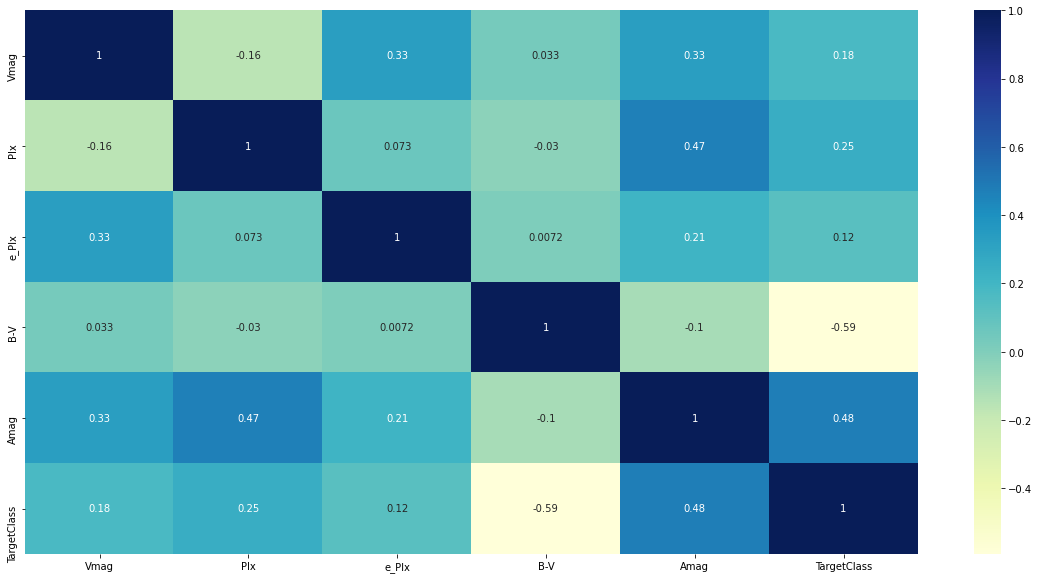

In [6]:
"""we can see here a very strong corrleation between the Amag
and the class of the target ,which """
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True,cmap="YlGnBu")

In [7]:
df.describe()

,Vmag,Plx,e_Plx,B-V,Amag,TargetClass
count,39552.000000,39552.000000,39552.000000,39552.000000,39552.000000,39552.000000
mean,7.921309,7.117378,1.109705,0.744336,16.050687,0.500000
std,1.308857,12.446291,0.788133,0.513987,2.443937,0.500006
min,-0.620000,-27.840000,0.420000,-0.400000,-0.350000,0.000000
25%,7.210000,2.430000,0.800000,0.358000,14.756514,0.000000
50%,8.160000,4.440000,0.990000,0.703000,16.020827,0.500000
75%,8.830000,8.232500,1.230000,1.129000,17.590542,1.000000
max,12.850000,772.330000,40.630000,3.440000,30.449015,1.000000


In [8]:
"""as we can see the index is as it should be"""
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39552 entries, 0 to 39551
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Vmag         39552 non-null  float64
 1   Plx          39552 non-null  float64
 2   e_Plx        39552 non-null  float64
 3   B-V          39552 non-null  float64
 4   SpType       39552 non-null  object 
 5   Amag         39552 non-null  float64
 6   TargetClass  39552 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 2.1+ MB


In [9]:
df['TargetClass'].unique()


array([1, 0], dtype=int64)

In [10]:
"""after reading how the kaggle user cleaned the data
i noticed that he used the SpType to decide the target of the
star , which means it could create a back door and disturb my model
for now ill decide to drop it , after my model is finished ill try and
add it so i can see if it's really means that"""
df=df.drop(columns=['SpType'])

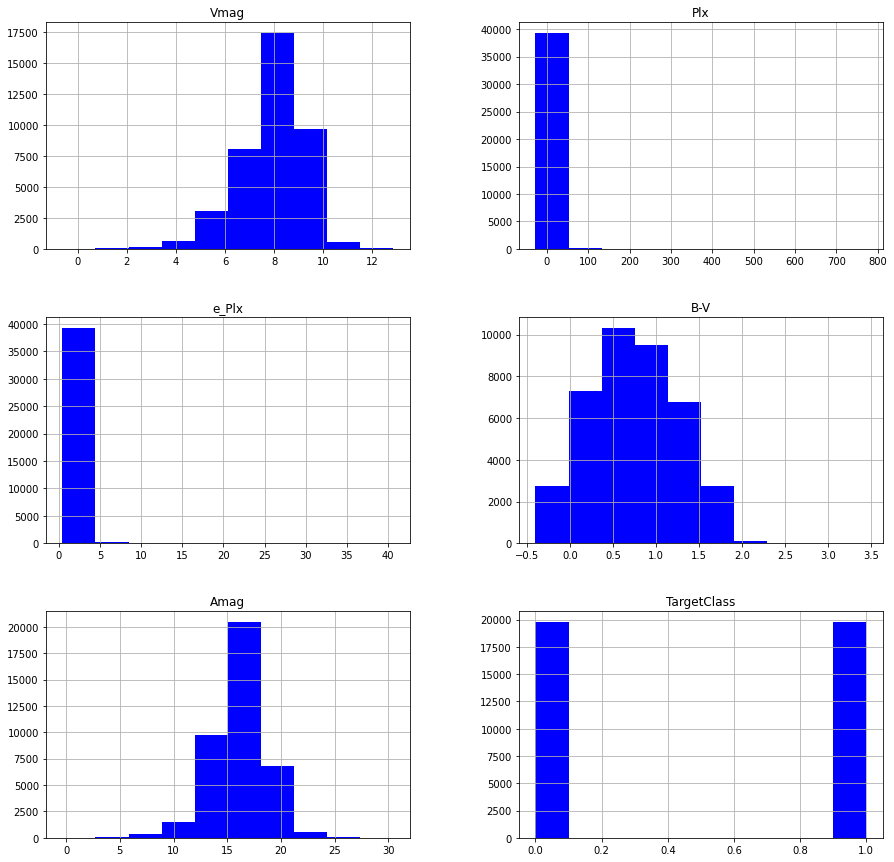

In [11]:
"""now the author also said that there might be too of high
of plx error , so ill check the mean and 50% and 75% and drop most of the above"""
df.hist(figsize=(15,15),color='b')
plt.show()

In [12]:
"""as we can see only 500~ rows with those can
really damage my model , since its a small number
in comparison to all the data , so ill drop those rows"""
df[df['e_Plx']>3].sort_values(by='e_Plx')
df=df[df['e_Plx']<3]

In [13]:
"""lets check if we have null rows"""
df.isnull().sum()

Vmag           0
Plx            0
e_Plx          0
B-V            0
Amag           0
TargetClass    0
dtype: int64

c:\users\talso\desktop\aiex\final project\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

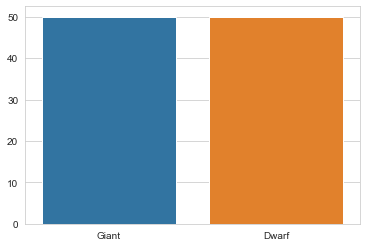

In [14]:
"""lets see how out data is divided in response to out targets"""
precnt=round(df['TargetClass'].value_counts()/len(df['TargetClass'])*100)
precnt
sns.set_style("whitegrid")
sns.barplot(['Giant','Dwarf'],y=[50,50])

In [15]:
"""we can see our data is divided 50-50 , which , i hope is good,lets try to model"""
x=df.drop('TargetClass',axis=1)
y=df['TargetClass']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [72]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model
fpr=dict()
tpr=dict()
tps=dict()
aucs=[]
i=0
#this function is used to get the fpr ,tpr,and auc of the model!
def get_stats(model,cx_test,cy_test):
    #global i,tps
    c_pred=model.predict(cx_test)
    c_prob=model.predict_proba(cx_test)
    c_prob = c_prob[:, 1]
    c_auc=roc_auc_score(cy_test,c_prob)
    c_fpr,c_tpr ,_=roc_curve(cy_test,c_prob)
    #i+=1
    print(classification_report(y_test,c_pred))
    print(confusion_matrix(y_test,c_pred))
    print(metrics.accuracy_score(y_test,c_pred)*100)
    print(f'{type(model)} ROC: =%.2f'%c_auc)
    return c_fpr,c_tpr,type(model).__name__


In [73]:
#logistic regression model
lr=LogisticRegression()
lr.fit(x_train,y_train)
fpr[i],tpr[i],tps[i]=get_stats(lr,x_test,y_test)
i+=1
#get_score(y_test,lr_pred)

              precision    recall  f1-score   support

           0       0.90      0.85      0.88      3914
           1       0.86      0.90      0.88      3886

    accuracy                           0.88      7800
   macro avg       0.88      0.88      0.88      7800
weighted avg       0.88      0.88      0.88      7800

[[3339  575]
 [ 375 3511]]
87.82051282051282
<class 'sklearn.linear_model._logistic.LogisticRegression'> ROC: =0.93


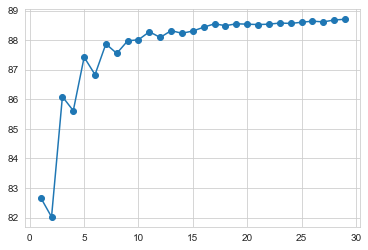

In [74]:
kn_scrs=[]
for l in range(1,30):
    k=KNeighborsClassifier(n_neighbors=l)
    k.fit(x_train,y_train)
    pred_l=k.predict(x_test)
    kn_scrs.append(metrics.accuracy_score(y_test,pred_l)*100)
plt.plot(range(1,30),kn_scrs,marker='o')

In [75]:
#found that 27 is the best n neighbors ,fitting the data
kn_cls=KNeighborsClassifier(n_neighbors=27)
kn_cls.fit(x_train,y_train)
fpr[i],tpr[i],tps[i]=get_stats(kn_cls,x_test,y_test)
i+=1

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      3914
           1       0.87      0.91      0.89      3886

    accuracy                           0.89      7800
   macro avg       0.89      0.89      0.89      7800
weighted avg       0.89      0.89      0.89      7800

[[3385  529]
 [ 359 3527]]
88.61538461538461
<class 'sklearn.neighbors._classification.KNeighborsClassifier'> ROC: =0.94


In [76]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train,y_train)
fpr[i],tpr[i],tps[i]=get_stats(dummy_clf,x_test,y_test)
i+=1

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      3914
           1       0.00      0.00      0.00      3886

    accuracy                           0.50      7800
   macro avg       0.25      0.50      0.33      7800
weighted avg       0.25      0.50      0.34      7800

[[3914    0]
 [3886    0]]
50.17948717948718
<class 'sklearn.dummy.DummyClassifier'> ROC: =0.50


c:\users\talso\desktop\aiex\final project\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\talso\desktop\aiex\final project\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\talso\desktop\aiex\final project\venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

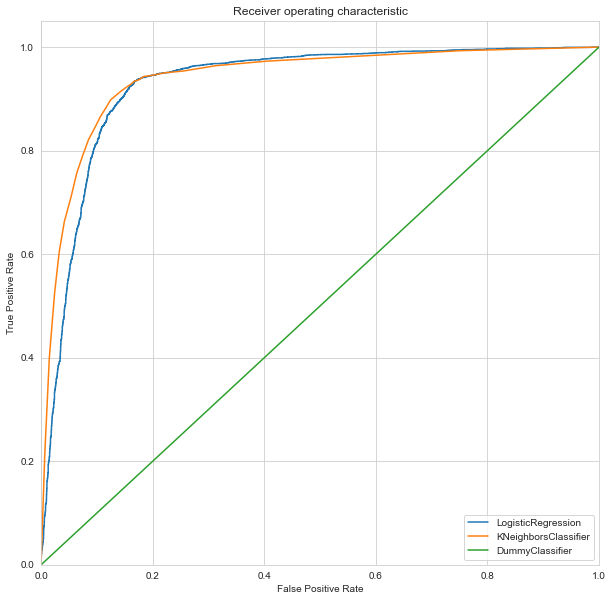

In [77]:
plt.figure(figsize=(10,10))
for j in range(len(fpr)):
    plt.plot(fpr[j],tpr[j],label=f'{tps[j]}')
plt.legend()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()